In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from lifelines.plotting import plot_lifetimes, rmst_plot, qq_plot
from lifelines import KaplanMeierFitter, WeibullFitter, NelsonAalenFitter, CoxPHFitter, LogLogisticFitter, \
                      LogNormalFitter, ExponentialFitter, PiecewiseExponentialFitter
from lifelines.utils import restricted_mean_survival_time

styles = [dict(selector="caption",
    props=[("text-align", "center"),
    ("font-size", "150%"),
    ("color", 'black')])] 

# &emsp;  &emsp;  Analýza dát o prežití Veteran Disease Trial


###  Autor: Emanuel Frátrik
###  Dátum: 30.5.2022

## 1 Úvod

V tomto protokole sa pokúsime analyzovať cenzorovaná dáta o liečbe veteránov. Konkrétne je našou úlohou analýza pacientov vo veku nad 60 rokov (age>60) so štandardnou liečbou (treat=1) vs s liečbou placebom (treat=2). Budeme riešiť nasledovné úlohy:

1. Odhad času dožitia v daných dvoch skupinách pomocou parametrických a neparametrických metód pre cenzorované dáta.

2. Porovnáme charakteristiky ako MTTF, mediánové časy dožitia, funkciu dožitia atď. medzi spomínanými skupinami. 
3. Pokúsime sa aplikovať Coxov PH model ak to bude možné.

### 2 Prieskumová analýza
Nakoľko máme dáta prístupné v csv formáte, ktorý obsahuje aj doplnkové komentáre tak tieto dáta najprv očistíme a extrahujeme spomínané dve skupiny (placebo vs štandard). Nižšie môžme vidieť popis premenných vyskytujúcich sa v datasete a taktiež náhľad na očistené dáta.


In [44]:
# data cleaning because there were comments 
with open('/home/emanuel/Documents/Matematika/Spolahlivostna_analyza/SKE_VeteranClinicTrial_modif.csv', 'r',
            encoding='ISO-8859-1') as f:
    lines = f.readlines()
    splited = [';'.join(line.split(';')[:8]).replace('\n', '') for line in lines]

    with open('/home/emanuel/Documents/Matematika/Spolahlivostna_analyza/VeteranClinicTrial_cleaned.csv',
              'w') as f:
        f.write('\n'.join(splited))

#### Popis dát
* treat - treatment (1= standard/lék, 2= test/placebo)
* cell - cell type (1= squamous, 2= small, 3= adeno, 4= large)
* survt - survival time (days)
* cens - status (0= censored, 1= died)
* KAR - performance status - Karnofsky score (0= worst,...,100= best)
* didur - disease duration from diagnosis to treatment (months)
* age - age (years)
* prith - prior therapy (0= none, 10= some)
* Pozn: Karnofsky score KAR<=30 (úplná hospitalizace), 30<KAR<=60 (částečná hospitalizace), KAR>60 (vlastní péče bez hospitalizace)

In [45]:
data = pd.read_csv('/home/emanuel/Documents/Matematika/Spolahlivostna_analyza/VeteranClinicTrial_cleaned.csv',
                   sep=';', 
                  na_values=-999., na_filter=True)
styled_data = data.iloc[np.r_[0:5, -5:0]].style.set_caption("Náhľad na dáta").set_table_styles(styles)

styled_data

,treat,cell,survt,cens,KAR,didur,age,prith
0,1,1,72,0,60,7,69,0
1,1,1,411,1,70,5,64,10
2,1,1,228,1,60,3,38,0
3,1,1,126,1,60,9,63,10
4,1,1,118,1,70,11,65,10
132,2,4,133,0,75,1,65,0
133,2,4,111,1,60,5,64,0
134,2,4,231,1,70,18,67,10
135,2,4,378,1,80,4,65,0
136,2,4,49,1,30,3,37,0


 Po očistení dát nás určite zaujímajú popisné štatistiky v jednotlivých skupinách. Nižšie môžme vidieť tabuľky zobrazujúce deskriptívne štatistiky pre skupinu pacientov liečených štandardne a pre skupinu, ktorá dostávala placebo. Obe skupiny pacientov majú zhruba rovnaký počet pozorovaní (38 a 39) a taktiež zhruba rovnaký počet (~30%) pozorovaní bol cenzorovaný. V skupine so štandardnou sa pacienti dožili priemerne 107 dní pričom maximum bolo 411 dní a medián 89 dní. V skupine s placebom sa pacienti priemerne dožili 100 dní s maximom 467 dní a mediánom 53 dní. `Poznamenajme, že dané priemery aj mediány boli vypočítané s použitím cenzorovaných dát takže poskytujú veľmi podhodnotené odhady daných veličín a preto slúžia len na hrubý náhľad na dáta a nie ako podklad tvoreniu záverov o prežití pacientov v skupinách.`

In [46]:
data2 = data[data['age'] > 60]
data_standard = data2[data2.treat == 1]

desc_standard = data_standard.describe()
styled_desc_std = desc_standard.style.set_caption("Deskriptívne štatistiky skupiny so štandardnou liečbou").set_table_styles(styles)
styled_desc_std


,treat,cell,survt,cens,KAR,didur,age,prith
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,1.000000,2.210526,107.526316,0.736842,58.026316,9.473684,65.710526,3.421053
std,0.000000,1.043847,100.487121,0.446258,17.224255,10.536261,3.726515,4.807829
min,1.000000,1.000000,7.000000,0.000000,20.000000,1.000000,61.000000,0.000000
25%,1.000000,1.250000,30.250000,0.250000,42.500000,4.000000,63.000000,0.000000
50%,1.000000,2.000000,89.500000,1.000000,60.000000,5.500000,65.000000,0.000000
75%,1.000000,3.000000,152.500000,1.000000,70.000000,11.750000,67.750000,10.000000
max,1.000000,4.000000,411.000000,1.000000,90.000000,58.000000,81.000000,10.000000


In [47]:
data_placebo = data2[data2.treat == 2]

desc_placebo = data_placebo.describe()
styled_desc_plc = desc_placebo.style.set_caption("Deskriptívne štatistiky skupiny s placebom").set_table_styles(styles)
styled_desc_plc



,treat,cell,survt,cens,KAR,didur,age,prith
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,2.000000,2.435897,100.307692,0.717949,55.897436,6.846154,66.179487,1.794872
std,0.000000,1.071027,116.165525,0.455881,22.356907,7.002024,4.122287,3.887764
min,2.000000,1.000000,1.000000,0.000000,10.000000,1.000000,61.000000,0.000000
25%,2.000000,2.000000,25.000000,0.000000,40.000000,2.500000,63.000000,0.000000
50%,2.000000,2.000000,53.000000,1.000000,60.000000,4.000000,65.000000,0.000000
75%,2.000000,3.000000,111.000000,1.000000,70.000000,9.000000,69.000000,0.000000
max,2.000000,4.000000,467.000000,1.000000,90.000000,36.000000,81.000000,10.000000


Dáta v skupinách s normalnou liečbou a placebom môže vidieť aj vizuálne znázornené na obrázkoch nižšie. Červenou sú znázornený pacienti bez cenzoringu a modrou cenzorované doby života pacientov. Podľa rôznych dĺžok dožitia v cenzorovaných pozorovaniach sa zdá, že dochádzalo k náhodnemu cenzorovaniu a nie cenzorovaniu časom resp. koncom štúdie.

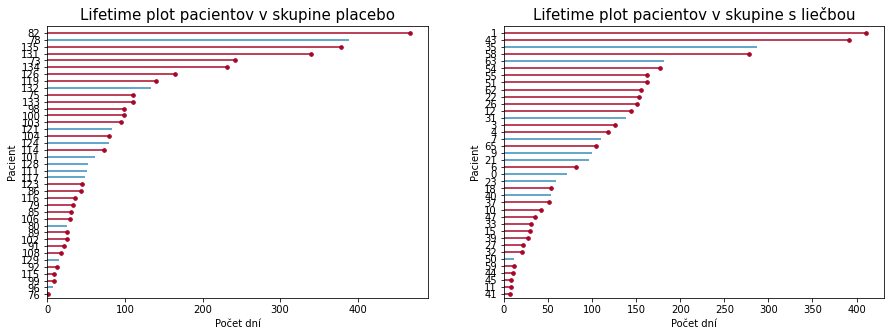

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

plc = plot_lifetimes(data_placebo.survt, event_observed=data_placebo.cens, ax=ax[0])
plc.set_xlabel("Počet dní")
plc.set_ylabel("Pacient")
plc.set_title("Lifetime plot pacientov v skupine placebo", fontsize=15)

std = plot_lifetimes(data_standard.survt, event_observed=data_standard.cens, ax=ax[1])
std.set_xlabel("Počet dní")
std.set_ylabel("Pacient")
std.set_title("Lifetime plot pacientov v skupine s liečbou", fontsize=15)

plt.show()

Boxplot nižšie reprezentuje porovnanie časov dožitia v oboch skupinách pričom dáta sú ešte oddelené podľa toho či boli cenzorované. Z obrázku sa zdá, že v skupine bez cenzorovaných dát nie je vidieť výrazný rozdiel medzi skupinami so štandardnou liečbou  a placebom. Naopak cenzorované dáta na prvý pohľad naznačuj, že by mohol existovať rozdiel medzi mediánovými dobami dožitia medzi skupinami so štandardnou liečbou  a placebom.  `Opäť poznamenajme, že aj tento prístup odhadu mediánovej doby dožitia je nesprávny pretože uvažuje len jedincov, ktorý umreli resp. len tých, ktorí boli cenzorovaných a slúži teda len na grafický vhľad do dát. Na relevantný odhad mediánových časov dožitia musíme teda aplikovať štandardné metódy analýz prežitia s cenzorovanými dátami čo budeme popisovať v nasledujúcich sekciách.`

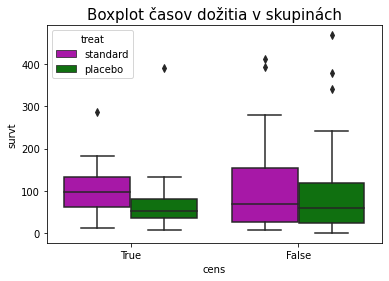

In [49]:
data3 = data2.copy(deep=True)
data3['treat'] = data3['treat'].replace({1: 'standard', 2: 'placebo'})
data3['cens'] = data3['cens'].replace({0: 'True', 1: 'False'})

box = sns.boxplot(x="cens", y="survt",
            hue="treat", palette=["m", "g"],
            data=data3)
box.set_title('Boxplot časov dožitia v skupinách', fontsize=15)
plt.show()

## 3 Modely
###  3.1 Neparametrický model

Ako vieme tak alternatívou k odhadom pomocou empirickej distribučnej funkcie resp. empirickej funkcii prežitia pri cenzorovaných dátach je Kaplan-Meirov model. Ide o základný neparametrický model na odhad survival funkcie $S_T(t)= P(T>t)$. Z tohto odhadu môže ďalej získať štatistiky ako strednú dobu života alebo mediánovú dobu života. Použitím taylorovho rozkladu logaritmu sa dá odvodiť Nelson-Aalenov odhad kumulatívnej hazard funkcie $\Lambda_T(t)$.
Odhad survival funkcie pre obe skupiny vidíme na obrázku nižšie. Survival funkcia pre skupinu so štandardnou liečbou sa zdá byť spočiatku veľmi podobná až zhruba v čase 90 dní sa táto krivka odkláňa od krivky pre pacientov s placebom. V čase zhruba 150 dní sa krivky krížia a krivka pre pacientov so štandardnou liečbou mierne podlezie krivku pre pacientov s placebom. Ďalej vyzerajú krivky zhruba rovnako. Samotné kríženie indikuje nesplnenie predpokladu o propočných hazard rate-och medzi skupinami. 

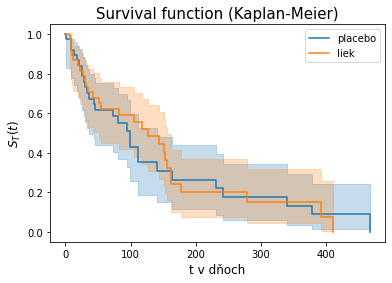

In [50]:
groups = data2['treat']
is_placebo = (groups == 2)

kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

#fig, ax = plt.subplots(1, 2, figsize=(15,5))


kmf1.fit(durations = data2[is_placebo]['survt'], event_observed=data2[is_placebo]['cens'], label='placebo')
ax = kmf1.plot_survival_function()

mean_placebo = restricted_mean_survival_time(kmf1.survival_function_)  # this is mean life
median_placebo = kmf1.median_survival_time_
#kmf.conditional_time_to_event_

kmf2.fit(durations = data2[~is_placebo]['survt'], event_observed=data2[~is_placebo]['cens'], label='liek')
ax = kmf2.plot_survival_function(ax=ax)

mean_standard = restricted_mean_survival_time(kmf2.survival_function_)  # this is mean life
median_standard = kmf2.median_survival_time_

ax.set_xlabel('t v dňoch', fontsize = 12)
ax.set_ylabel('$S_T(t)$', fontsize = 12)
ax.set_title('Survival function (Kaplan-Meier)', fontsize = 15)
plt.show()

$MTTF$ a $t_{med}$ pre obe skupiny sú zhrnuté v tabuľke nižšie.V prípade $MTTF$ sa zdá byť rozdiel zanedbateľný t.j. liečba v priemere nepredlžuje život. $t_{med}$ na druhú stranu poukazuje na istý prínos liečby. 

In [51]:
vals2 = [[mean_placebo, median_placebo],[mean_standard, median_standard] ]
non_param_stats = pd.DataFrame(index = ['Placebo', 'Liek'],
                     columns=['MTTF', '$t_{med}$'],
                           data=vals2)

non_param_stats_styled = non_param_stats.style.set_caption("Odhadnuté charakteristiky").set_table_styles(styles)

non_param_stats_styled

,MTTF,$t_{med}$
Placebo,131.433454,99.000000
Liek,134.909837,126.000000


Ako sme už spomínali tak, použitím aproximácie pre logaritmus sa dá odvodiť tzv. Nelson-Aalenov odhad kumulatívnej hazard funkcie. Na obrázkoch nižšie môžme vidieť práve takýto odhad. Naľavo je odhad $\Lambda_T(t)$ a napravo $\lambda_T(t)$. V prípade hazard funkcie  $\lambda_T(t)$ bolo treba na odhad využiť vyhladzovaciu procedúru a preto nie je daný graf veľmi spoľahlivý. Na druhú stranu kumulatívna hazard funkcia $\Lambda_T(t)$ je odhadnutá len na základe dát. Jej priebeh nie je konvexný ani konkávny a preto nejde teda o IFR ani DFR typy ale o nejaký hybrid medzi nimi.

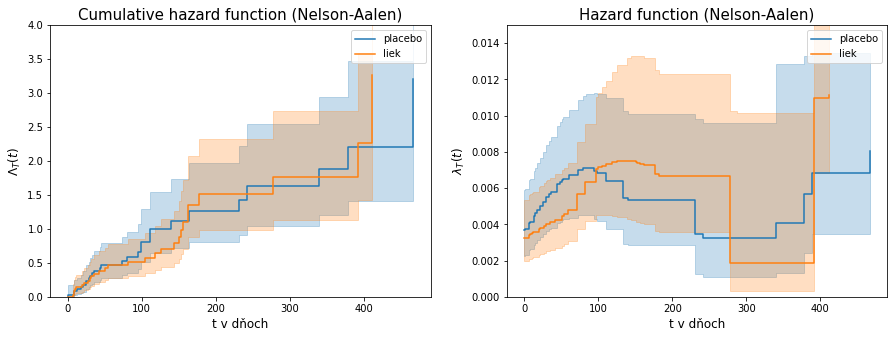

In [52]:
naf1 = NelsonAalenFitter(nelson_aalen_smoothing=False)
naf2 = NelsonAalenFitter(nelson_aalen_smoothing=False)

fig, ax = plt.subplots(1, 2, figsize=(15,5))

naf1.fit(durations = data2[is_placebo]['survt'], event_observed=data2[is_placebo]['cens'], label='placebo')
ax1 = naf1.plot(ax=ax[0])
ax2 = naf1.plot_hazard(bandwidth=100, ax=ax[1])

#mean_placebo = restricted_mean_survival_time(naf.survival_function_)  # this is mean life
#median_placebo = naf.median_survival_time_
#kmf.conditional_time_to_event_

naf2.fit(durations = data2[~is_placebo]['survt'], event_observed=data2[~is_placebo]['cens'], label='liek')
ax1 = naf2.plot(ax=ax[0])
ax2 = naf2.plot_hazard(bandwidth=100, ax=ax[1])

#mean_standard = restricted_mean_survival_time(naf.survival_function_)  # this is mean life
#median_standard = naf.median_survival_time_

ax1.set_xlabel('t v dňoch', fontsize = 12)
ax1.set_ylabel('$\Lambda_T(t)$', fontsize = 12)
ax1.set_title('Cumulative hazard function (Nelson-Aalen)', fontsize = 15)
ax1.set_ylim(0, 4)
ax2.set_xlabel('t v dňoch', fontsize = 12)
ax2.set_ylabel('$\lambda_T(t)$', fontsize = 12)
ax2.set_ylim(0, 0.015)
ax2.set_title('Hazard function (Nelson-Aalen)', fontsize = 15)
plt.show()

Poslednou metrikou, ktorou môžme porovnať študované skupiny je podmienený mediánový čas dožitia. Táto metrika popisuje mediánovú dobu prežitia subjektu za predpokladu, že sa dožil do času $t_o$. Platí teda
$$P(T>t_0 + t_{med} | T > t_0) = \frac{1}{2}$$. Ide teda o podobnú charakteristiku ako tzv. `mean residual life`. 
Na grafe nižšie je táto charakteristika odhadnutá pomocou Kaplan-Meirovho odhadu $S_T(t)$ ako funkcia času $t_0 $opäť pre obe skupiny. V čase $t_0=0$ máme pôvodný medianový čas dožitia, ktorý bol lepší pre skupinu s liečbou. Následne tieto krivky v oboch skupinách klesajú zhruba lineárne. V oboch skupinách nastáva náhly skok. Pre skupinu s placebom je to medzi $t_0 \in (90-110)$ a pre skupinu so štandardnou liečbou zhruba v intervale $(150-160)$. Takýto skok je zaujímavý nakoľko vlastne znamená, že za predpokladu dožitia sa 150 dní sa pacient s pravdepodobnosťou 50% dožije aspoň ďalších 25 dní ale ak sa dožije pacient $t_0=160$ dní tak sa už s pravdepodobnosťou 50% aspoň ďalších 250 dní. Pre pacienta (nad 60 rokov) podstupujúce liečbu je teda tento interval $(150-160)$ v istom zmysle kritickým.Čo takýto skok spôsobuje nám nie je jasné ale korešponduje s náhlym poklesom survival funkcie v intervale zhruba $(150-160)$ pre pacienta s liečbou prejavujúcim sa v podmienenej distribúcii $P(T>t_0 + t_{med} | T > t_0) = \frac{P(T>t_0 + t_{med})}{P(T > t_0)}$. Pravdepodobne ide o nejaký efekt ďalšej vysvetľujúcej premennej. Skoky pozorujeme aj v skupine s placebom. Celkovo sa podmienený mediánový čas dožitia spočiatku poukazuje v prospech liečby ale zhruba od $t_0=50$ dní sú charakteristiky pre obe skupiny rovnaké prípadne sa lepšie javí skupina s placebom.

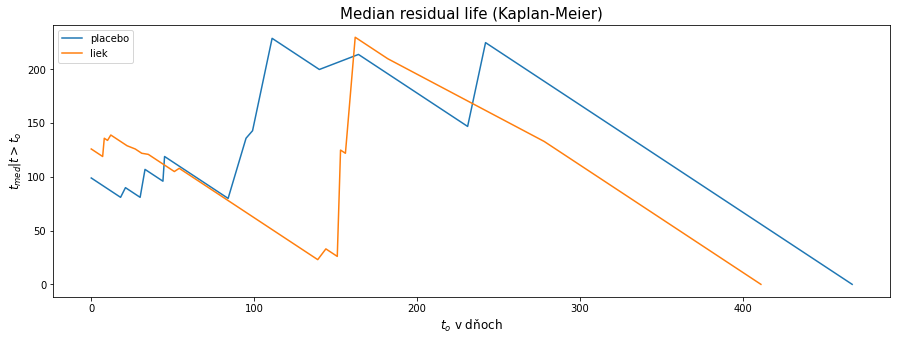

In [53]:
ctte_placebo = kmf1.conditional_time_to_event_
ctte_standard = kmf2.conditional_time_to_event_

fig, ax = plt.subplots(1, 1, figsize=(15,5))

ax.plot(ctte_placebo, label='placebo')
ax.plot(ctte_standard, label='liek')
ax.set_xlabel('$t_o$ v dňoch', fontsize=12)
ax.set_ylabel('$t_{med}| t > {t_o}$', fontsize=12)
ax.set_title('Median residual life (Kaplan-Meier)', fontsize=15)
plt.legend(loc="upper left")
plt.show()

### 3.2 Parametrický model

Namiesto neparametrických odhadov sa môžme pokúsiť získať parametrické odhady $S_T(t)$ a teda aj ostatné charakteristiky pre obe skupiny pacientov.
Na určenie vhodných kandidátov parametrických distribúcii použijeme QQ-ploty. Takéto QQ-ploty sú postupne vykreslené na obrázkoch nižšie pre obe skupiny zvlášť. QQ-ploty podľa nás vyzerajú veľmi podobne v oboch podskupinách a preto vyberáme Weibullovskú a loglogistickú distribúciu.

In [54]:
def plot_model(m1, m2, name):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    m1.plot_cumulative_hazard(ax=axes[0, 0])
    m2.plot_cumulative_hazard(ax=axes[0, 0])
    axes[0, 0].set_title(f"Cumulative hazard of {name} model", fontsize=15)
    axes[0, 0].set_ylabel("$\Lambda_T(t)$", fontsize=12)
    axes[0, 0].set_xlabel("t v dňoch", fontsize=12)
    #axes[0].set_ylim(0, 3)

    m1.plot_hazard(ax=axes[0, 1])
    m2.plot_hazard(ax=axes[0, 1])
    axes[0, 1].set_title(f"Hazard function of {name} model", fontsize=15)
    axes[0, 1].set_ylabel("$\lambda_T(t)$", fontsize=12)
    axes[0, 1].set_xlabel("t v dňoch", fontsize=12)
    #axes[1].set_ylim(0, 0.015)

    m1.plot_survival_function(ax=axes[1, 0])
    m2.plot_survival_function(ax=axes[1, 0])
    axes[1, 0].set_title(f"Survival function of {name} model", fontsize=15)
    axes[1, 0].set_ylabel("$S_T(t)$", fontsize=12)
    axes[1, 0].set_xlabel("t v dňoch", fontsize=12)
    #axes[1].set_ylim(0, 0.015)

    ctte_placebo = m1.conditional_time_to_event_
    ctte_standard = m2.conditional_time_to_event_

    axes[1, 1].plot(ctte_placebo, label='placebo')
    axes[1, 1].plot(ctte_standard, label='liek')
    axes[1, 1].set_xlabel('$t_o$ v dňoch', fontsize=12)
    axes[1, 1].set_ylabel('$t_{med}| t > {t_o}$', fontsize=12)
    axes[1, 1].set_title(f'Median residual life ({name})', fontsize=15)


    plt.show()

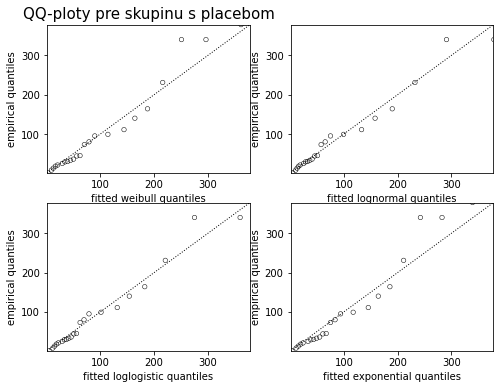

In [55]:
# placebo skupina
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)
axes[0].set_title('QQ-ploty pre skupinu s placebom', fontsize=15)

for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(data2[is_placebo]['survt'], data2[is_placebo]['cens'], label='placebo')
    qq_plot(model, ax=axes[i])

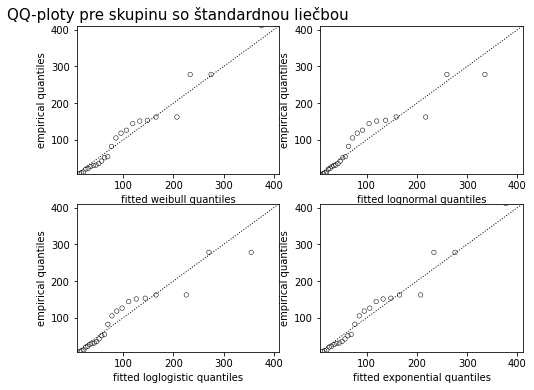

In [56]:
# standardna skupina
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)
axes[0].set_title('QQ-ploty pre skupinu so štandardnou liečbou', fontsize=15)

for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(data2[~is_placebo]['survt'], data2[~is_placebo]['cens'], label='liek')
    qq_plot(model, ax=axes[i])

#### 3.2.1 Weibullov model
Na fit dát použijeme najprv Weibullov model parametrizovaný dvomi parametrami tvaru ($\rho$) a škály ($\lambda$):
$$S_T(t) = \exp(-\left(\frac{t}{\lambda}\right)^{\rho})$$ V prípade $\rho=1$ získame exponenciálny model.
Parameter $\lambda$ môže byť interpretovateľný ako čas kedy 63.2% populácie zomrelo.
V tabuľkách nižšie vidíme postupne odhady parametrov $\rho$ a  $\lambda$ pre obe skupiny, ich konfidenčné intervaly prípadne test hypotézy rovnosti 1. Predovšetkým v prípade skupiny so štandadnou liečbou nebola zamietnúta hypotéze rovnosti $\rho=1$, čo efektívne vedie na exponenciálny model. 

In [57]:
wf1 = WeibullFitter().fit(data2[is_placebo]['survt'], data2[is_placebo]['cens'], label='placebo')
wf2 = WeibullFitter().fit(data2[~is_placebo]['survt'], data2[~is_placebo]['cens'], label='liek')

sum_placebo = wf1.summary
sum_liek = wf2.summary

sum_placebo_styled = sum_placebo.style.set_caption("Fit Weibullovho modelu pre skupinu s placebom").set_table_styles(styles)
sum_placebo_styled

mean_placebo = restricted_mean_survival_time(wf1.survival_function_)  # this is mean life
median_placebo = wf1.median_survival_time_

mean_standard = restricted_mean_survival_time(wf2.survival_function_)  # this is mean life
median_standard = wf2.median_survival_time_


#https://lifelines.readthedocs.io/en/latest/Examples.html#selecting-a-parametric-model-using-qq-plots
#   https://lifelines.readthedocs.io/en/latest/Examples.html#selecting-a-parametric-model-using-AIC

In [58]:
sum_liek_styled = sum_liek.style.set_caption("Fit Weibullovho modelu pre skupinu so štandardnou liečbou").set_table_styles(styles)
sum_liek_styled

,coef,se(coef),coef lower 95%,coef upper 95%,cmp to,z,p,-log2(p)
lambda_,145.993386,27.502737,92.089012,199.897761,1.000000,5.271962,0.000000,22.820826
rho_,1.005418,0.151341,0.708794,1.302041,1.000000,0.035797,0.971444,0.041797


Nižšie vidíme porovnanie grafov $S_T(t)$, $\Lambda_T(t)$, $\lambda_T(t)$ a median residual life po nafitovaní Weibullovho modelu. Porovnaním grafov $\Lambda_T(t)$ a odhadu pomocou Nelson-Aalenovho algoritmu musíme konštatovať, že model nepopisuje naše dáta dobre.

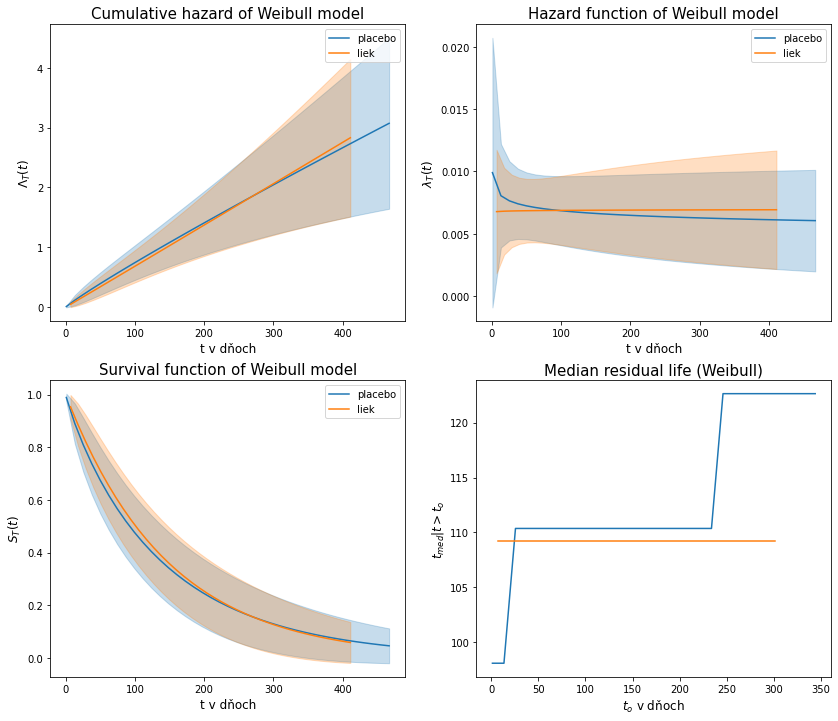

In [59]:
plot_model(m1=wf1, m2=wf2, name='Weibull')



In [60]:
vals2 = [[mean_placebo, median_placebo],[mean_standard, median_standard] ]
param_stats = pd.DataFrame(index = ['Placebo', 'Liek'],
                     columns=['MTTF', '$t_{med}$'],
                           data=vals2)

param_stats_styled = param_stats.style.set_caption("Odhadnuté charakteristiky pre Weibullov model").set_table_styles(styles)

param_stats_styled

,MTTF,$t_{med}$
Placebo,135.642275,92.541740
Liek,137.223703,101.394951


#### 3.2.2 Loglogistický model

Ďalším nafitovaným modelom je Loglogistický model s tvarom survival funkcie:
$$S_T(t) = \left(1 + \left(\frac{t}{\alpha}\right)^{\beta}\right)^{-1}$$
Nižšie môžme opäť vidieť tabuľku s hodnotami parametrov a taktiež už spomínané grafy. Porovnaním s Nelson-Aalenovým odhadom je zrejmé, že ani tento model nepopisuje dáta správne.

In [61]:
loglog1 = LogLogisticFitter().fit(data2[is_placebo]['survt'], data2[is_placebo]['cens'], label='placebo')
loglog2 = LogLogisticFitter().fit(data2[~is_placebo]['survt'], data2[~is_placebo]['cens'], label='liek')

sum_placebo = loglog1.summary
sum_liek = loglog2.summary

sum_placebo_styled = sum_placebo.style.set_caption("Fit Loglogistického modelu pre skupinu s placebom").set_table_styles(styles)
sum_placebo_styled

mean_placebo = restricted_mean_survival_time(loglog1.survival_function_)  # this is mean life
median_placebo = loglog1.median_survival_time_

mean_standard = restricted_mean_survival_time(loglog2.survival_function_)  # this is mean life
median_standard = loglog2.median_survival_time_


#https://lifelines.readthedocs.io/en/latest/Examples.html#selecting-a-parametric-model-using-qq-plots
#   https://lifelines.readthedocs.io/en/latest/Examples.html#selecting-a-parametric-model-using-AIC

In [62]:
sum_liek_styled = sum_liek.style.set_caption("Fit Loglogistického modelu pre skupinu so štandardnou liečbou").set_table_styles(styles)
sum_liek_styled

,coef,se(coef),coef lower 95%,coef upper 95%,cmp to,z,p,-log2(p)
alpha_,92.825338,21.420168,50.842580,134.808097,1.000000,4.286864,0.000018,15.751950
beta_,1.286942,0.198581,0.897731,1.676152,1.000000,1.444962,0.148468,2.751772


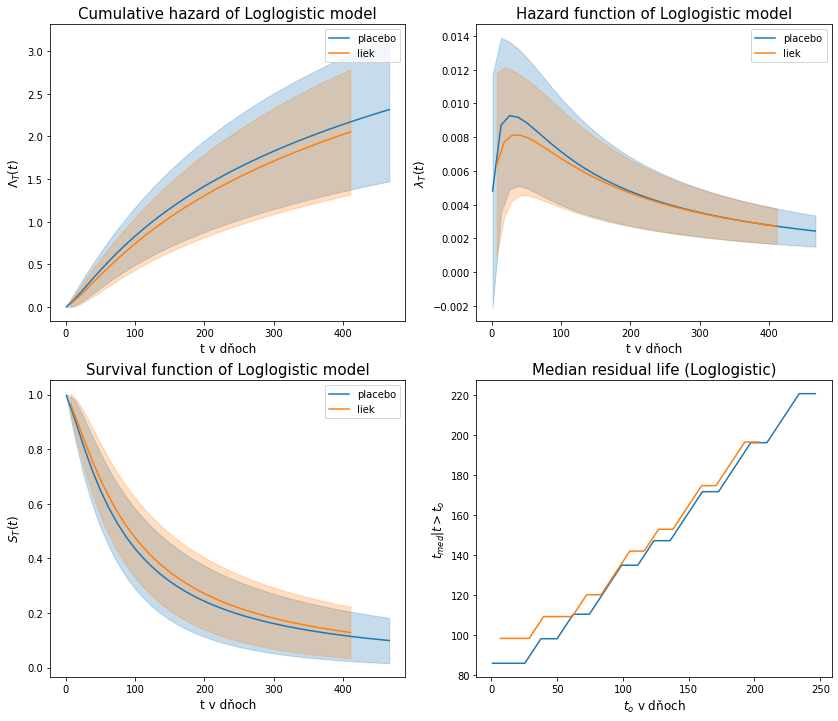

In [63]:
plot_model(m1=loglog1, m2=loglog2, name='Loglogistic')

In [64]:
vals2 = [[mean_placebo, median_placebo],[mean_standard, median_standard] ]
param_stats = pd.DataFrame(index = ['Placebo', 'Liek'],
                     columns=['MTTF', '$t_{med}$'],
                           data=vals2)

param_stats_styled = param_stats.style.set_caption("Odhadnuté charakteristiky pre Loglogistický model").set_table_styles(styles)

param_stats_styled

,MTTF,$t_{med}$
Placebo,140.766687,81.474603
Liek,145.762247,92.825338


#### 3.2.3 Po častiach exponenciálny model
Nakoľko, žiadne z vyskúšaných parametrických modelov nesedí na naše dáta, pokúsime sa modelovať $S_T(t)$ pomocou po častiach exponenciálneho modelu. V praxi ide len o to, že dáta rozdelíme podľa časových intervalov a na tieto aplikujeme samostatný exponenciálny model. V našom prípade sme zlomy časových intervalov nadefinovali na základe Nelson-Aalenovho plotu $\Lambda_T(t)$, tak aby podľa nás čo najlepšie vystihovali dáta. Odhady parametrov vidíme v tabuľkách nižšie. Na základe obrázkov a podobnosti kumulatívnej hazard funckie s tou odhadnutou Nelson-Meireovým odhadom možme považovať daný model za finálny. Čo sa týka charakteristík ako $MTTF$ a $t_{med}$ sú závery podobné ako pri neparametrických odhadoch a síce $MTTF$ sú v podstate rovnaké pre obe analyzované skupiny pacientov a $t_{med}$ poukazuje na mierný prínos liečby v porovnaní s placebom.

In [65]:
pwe1 = PiecewiseExponentialFitter(breakpoints=[50, 90, 150, 160, 190, 250, 350]).fit(data2[is_placebo]['survt'], data2[is_placebo]['cens'], label='placebo')
pwe2 = PiecewiseExponentialFitter(breakpoints=[50, 90, 150, 160, 190, 250, 350]).fit(data2[~is_placebo]['survt'], data2[~is_placebo]['cens'], label='liek')

sum_placebo = pwe1.summary
sum_liek = pwe2.summary

sum_placebo_styled = sum_placebo.style.set_caption("Fit po častiach exponenciálneho modelu pre skupinu s placebom").set_table_styles(styles)
sum_placebo_styled

mean_placebo = restricted_mean_survival_time(pwe1.survival_function_)  # this is mean life
median_placebo = pwe1.median_survival_time_

mean_standard = restricted_mean_survival_time(pwe2.survival_function_)  # this is mean life
median_standard = pwe2.median_survival_time_



#https://lifelines.readthedocs.io/en/latest/Examples.html#selecting-a-parametric-model-using-qq-plots
#   https://lifelines.readthedocs.io/en/latest/Examples.html#selecting-a-parametric-model-using-AIC

In [66]:
sum_liek_styled = sum_liek.style.set_caption("Fit po častiach exponenciálneho modelu pre skupinu so štandardnou liečbou").set_table_styles(styles)
sum_liek_styled

,coef,se(coef),coef lower 95%,coef upper 95%,cmp to,z,p,-log2(p)
lambda_0_,125.677359,36.139497,54.845246,196.509472,1.000000,3.449892,0.000561,10.800198
lambda_1_,279.894101,163.095999,-39.768183,599.556385,1.000000,1.710000,0.087266,3.518438
lambda_2_,221.425662,111.560294,2.771503,440.079821,1.000000,1.975843,0.048173,4.375646
lambda_3_,30.031908,17.357381,-3.987935,64.051750,1.000000,1.672597,0.094407,3.404968
lambda_4_,54.008563,30.996026,-6.742533,114.759658,1.000000,1.710173,0.087234,3.518967
lambda_5_,45360.433035,440955.911505,-818897.272286,909618.138356,1.000000,0.102866,0.918069,0.123325
lambda_6_,265.543615,266.088906,-255.981057,787.068288,1.000000,0.994193,0.320129,1.643274
lambda_7_,51.759473,36.784341,-20.336510,123.855456,1.000000,1.379921,0.167611,2.576811


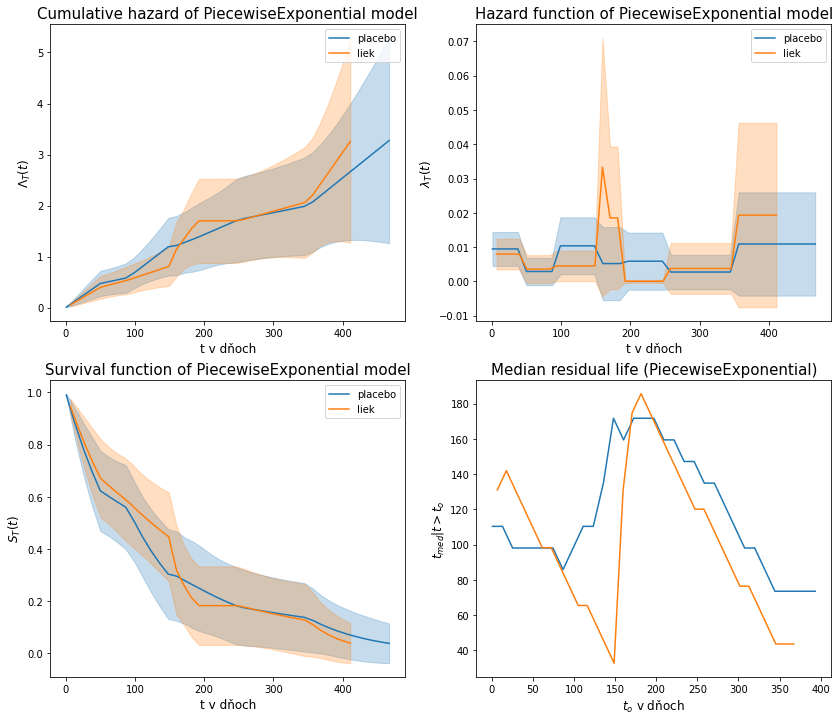

In [67]:
plot_model(m1=pwe1, m2=pwe2, name='PiecewiseExponential')

In [68]:
vals2 = [[mean_placebo, median_placebo],[mean_standard, median_standard] ]
param_stats = pd.DataFrame(index = ['Placebo', 'Liek'],
                     columns=['MTTF', '$t_{med}$'],
                           data=vals2)

param_stats_styled = param_stats.style.set_caption("Odhadnuté charakteristiky pre po častiach exponenciálny model").set_table_styles(styles)

param_stats_styled

,MTTF,$t_{med}$
Placebo,136.766811,100.06357979297627
Liek,138.699025,123.74346714408753


### 3.3 CoxPH model a log-rank test
Na porovnávanie dvoch funkcii prežitia resp. funkcii prežitia v podskupinách môžme použiť vizuálne porovnanie pomocou Kaplan-Meirovho plotu. V prípade diskrétnych skupín ako je to aj v našom prípade môžme použiť tzv. log-rank test, ktorý testuje zhodnosť dvoch funkcii prežitia. Alternatívou k použitiu log-rank testu je tzv. Coxov PH model, ktorý umožňuje naviac zarátať a odhadnúť efekty dodatočných regresorov na celkový čas dožitia. Jeho nespornou výhodou je taktiež interpretovateľnosť parametrov v zmysle tzv. hazard ratio, ktorá je efektívne rovnaká ako pomer šancí (odds ratio) v logistickej regresii. Matematicky môže byť Coxov model definovaný nasledovne: 
$$\lambda(t) = \lambda_0(t)\exp(\textbf{X}\beta)$$
Coxov model ako aj log-rank test ale vyžadujú splnenie PH (proportional hazard) predpoklady. Tento PH predpoklad sa dá vizuálne overiť v prípade diskrétnych premenných ako je to aj v našom prípade pomocou loglog grafu survival funkcie. V optimálnom prípade (splenenie PH predpokladu) by mali byť krivky zhruba paralelné. Takýto graf je vykreslený na obrázku nižšie. Vidíme, že krivky nie sú paralelné a krížia sa čo naznačuje nevhodnosť použitia Coxovho PH modelu resp. log-rank testu na porovnávanie naších skupín pacientov.

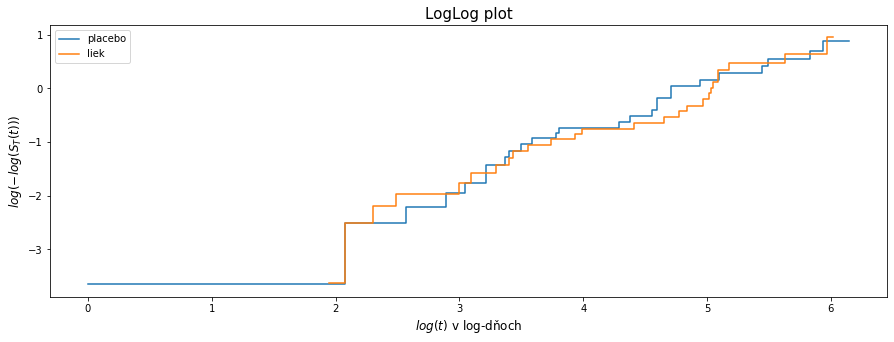

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax = kmf1.plot_loglogs(ax=ax)
ax = kmf2.plot_loglogs(ax=ax)

ax.set_xlabel('$log(t)$ v log-dňoch', fontsize = 12)
ax.set_title('LogLog plot', fontsize = 15)
ax.set_ylabel('$log(-log(S_T(t)))$', fontsize = 12)
plt.show()

### 3.4 Ďalšie možnosti porovnania skupín
Inými vhodnými metrikami na porovnanie dvoch kriviek prežitia sú už spomínané `mean survival time` alebo `median survival time`. Nakoľko ale chvosty rozdelení bývajú často zaťažené chybou tak sa používa tzv. `restricted mean survival time` ($RMST(t_0)$) ako vhodné metrika na porovnanie skupín predovšetkým pri nesplnení PH predpokladu.  Rozdiely v ($RMST(t_0)$) môžu byť taktiež podrobené regresnej analýze na odhady efektov ďalších premenných. Takáta analýza ale z časového hľadiska nebola vykonaná. $RMST(t_0)$ definujeme nasledovne:
$$RMST(t_0) = \int_0^{t_0}S_T(\tau)d\tau$$V prípade $t_0=\infty$ získame $MTTF$. V našom prípade sme zvolili ako limit $t_0=300$ dní. Na obrázkoch nižšie môžme vidieť vyčíslenie tejto metriky pre skupiny s placebom ale aj štandardnou liečbou pričom bol použitý Kaplan-Meirov odhad $S_T(t)$. Taktiež vidíme, že rozdiel medzi RMST je zhruba 7 dní v prospech štandardnej liečby. Zdá sa teda, že liečba má istý, ale z nášho pohľadu, veľmi zanedbateľný prínos na predĺženie života.

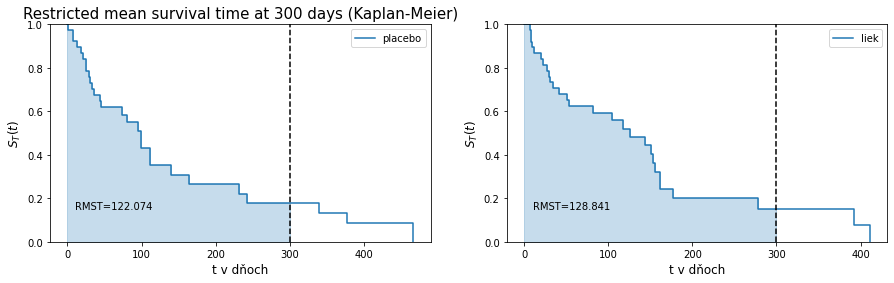

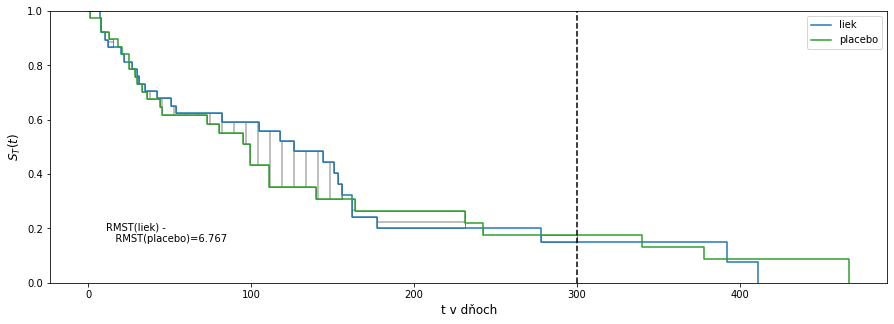

In [70]:
time_limit = 300

rmst_placebo = restricted_mean_survival_time(kmf1, t=time_limit)

rmst_liek = restricted_mean_survival_time(kmf2, t=time_limit)

fig, ax = plt.subplots(1, 2, figsize=(15,4))

rmst_plot(kmf1, t=time_limit, ax=ax[0])

ax[0].set_title('Restricted mean survival time at 300 days (Kaplan-Meier)', fontsize=15)
ax[0].set_xlabel('t v dňoch', fontsize=12)
ax[0].set_ylabel('$S_T(t)$', fontsize=12)

rmst_plot(kmf2, t=time_limit, ax=ax[1])
ax[1].set_xlabel('t v dňoch', fontsize=12)
ax[1].set_ylabel('$S_T(t)$', fontsize=12)

fig2, ax2 = plt.subplots(1, 1, figsize=(15,5))

rmst_plot(kmf2, model2=kmf1, t=time_limit, ax=ax2)


ax2.set_xlabel('t v dňoch', fontsize=12)
ax2.set_ylabel('$S_T(t)$', fontsize=12)


plt.show()

V prípade nášho finálneho parametrického modelu sú výsledky podobné t.j. v metrike $RMST(300)$ sa skupiny s placebom a štandardnou liečbou líšia len zanedbateľne o hodnotu 6.7.

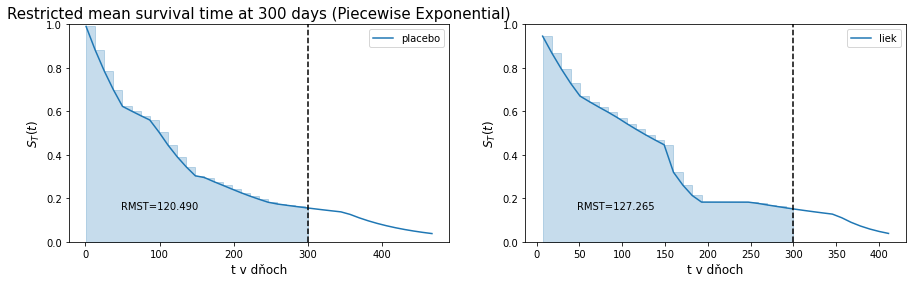

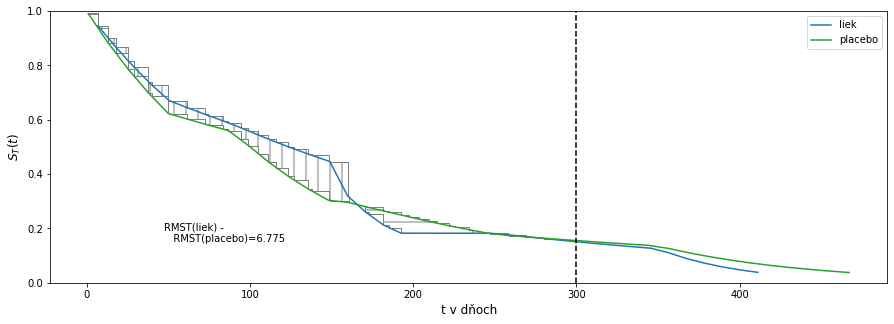

In [71]:


fig, ax = plt.subplots(1, 2, figsize=(15,4))

rmst_plot(pwe1, t=time_limit, ax=ax[0])

ax[0].set_title('Restricted mean survival time at 300 days (Piecewise Exponential)', fontsize=15)
ax[0].set_xlabel('t v dňoch', fontsize=12)
ax[0].set_ylabel('$S_T(t)$', fontsize=12)

rmst_plot(pwe2, t=time_limit, ax=ax[1])
ax[1].set_xlabel('t v dňoch', fontsize=12)
ax[1].set_ylabel('$S_T(t)$', fontsize=12)

fig2, ax2 = plt.subplots(1, 1, figsize=(15,5))

rmst_plot(pwe2, model2=pwe1, t=time_limit, ax=ax2)


ax2.set_xlabel('t v dňoch', fontsize=12)
ax2.set_ylabel('$S_T(t)$', fontsize=12)


plt.show()

## 4 Záver

V tomto protokole sme analyzovali časy prežitia z klinickej štúdie veteránov (Veteran disease trial), konkrétne sme porovnávali pacientov vo vekovej kategórii nad 60 rokov v rámci skupín s placebom a štandardnou liečbou. Na odhad funkcie prežitia $S_T(t)$ sme použili neparametrické ale aj parametrické metody. V prípade parametrických modelov sme boli nútený použiť po častiach exponenciálny model. Charakteristiky ako $MTTF$ (mean time to failure) prípadne $t_{med}$ (mediánový čas dožitia) poukazovali na minimálne zlepšenie priemerných časov dožitia v prípade  liečby testovanou procedúrou namiesto placeba. Zaujímavým zistením bolo, že v prípade liečby štandardnou testovanou procedúrou existuje akási kritická oblasť časov dožitia kde dochádza k náhlej zmene očakávaného mediánového zbytkového času dožitia (median residual life). V prípade odhadu pomocou Kaplan-Meierovej metódy je táto kritická oblasť zhruba medzi 150-tym a 160-tym dňom prežitia. Odhady median residual life konkrétne naznačovali pre pacientov so štandardnou liečbou, že v prípade dožitia sa 150 dní majú 50% pravdepodobnosť dožitia sa aspoň ďalších 25 dní pričom ak sa dožil pacient  $t_0=160$ dní tak sa už s pravdepodobnosťou 50% dožije aspoň ďalších 250 dní čo je značný nárast. Podobný záver ohľadom akejsi kritickej oblasti platil aj pre skupinu s placebom ale bol menej výrazný. Čo takýto trend spôsobilo nám nie je jasné a bolo by treba ho preskúmať s pomocou uva6ovania efektov od ďalších premenných v datasete. Takúto analýzu sme nevykonali nakoľko po preskúmaní loglog grafu funkcie prežitia sa ukázali byť nesplenené predpoklady Coxovho PH modelu a teda by jeho použitie resp. použitie log-rank testu na prorovnanie skupín mohlo viesť k zavádzajúcim záverom. Ako ďalšie porovnanie časov prežitia v oboch skupinách bola navrhnutá ďalšia integrálna charakteristika známa ako restricted mean survival time ($RMST(t_0)$). Rozdiel ($RMST(300)$) charakteristiky pre obe skupiny opäť podľa nás naznačoval minimálnu účinnosť liečby voči placebu.  